In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
import os
import sys

import pandas as pd

from matplotlib import animation, pyplot, rc

import httpimport
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

In [0]:
#@title Logistic regression implementation
#This code is part of homework assignment and is removed on purpose


Suppose you have gathered some data about heights and weight of people (the dataset we will use comes form https://vincentarelbundock.github.io/Rdatasets/datasets.html). The data contains information about the self-reported and measured heights and weights along with the sex of each person.

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/lectures/03-davis.csv',
                   index_col=0)
data.head()

,sex,weight,height,repwt,repht
1,M,77,182,77.0,180.0
2,F,58,161,51.0,159.0
3,F,53,161,54.0,158.0
4,M,68,177,70.0,175.0
5,F,59,157,59.0,155.0


Knowing the height of a person, can we predict the sex?

Clearly, the average male is taller than the average woman. We notice that in our dataset there are no woman above 180 cm and no man below 160 cm. Predicting the sex in those regions seems easy, however what about someone 170 cm tall?

What would like to build a model that can predict the conditional probability of sex given the height of a person. The input to the model is going to be a single real-valued number, the height, while the output needs to be a probability value, that is a real number form the $[0,1]$ range.

Please note thet for visualization purposes a small jitter is added to the encoded sex variable. It helps to see overlapping points.

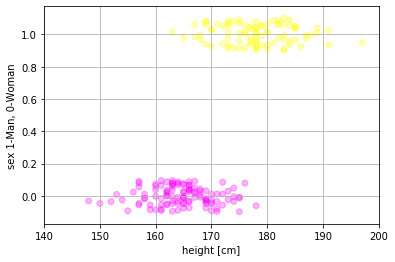

In [0]:
jitter=0.10
scatter(data.height, (data.sex=='M') + (np.random.rand(*data.sex.shape)* 2.0 - 1.0) * jitter, 
        c=data.sex=='M', cmap='spring', alpha=0.3)
xlim(140,200)
xlabel('height [cm]')
ylabel('sex 1-Man, 0-Woman')
grid(True)

## Logistic regression is for classification

We have learned about linear regression - predicting the value of a continuous variable. This was the task in the house pricing and the height vs weight problems we have seen. However, a linear regression model has an unbounded output. To predict the class of a sample (in our example the sex of a person) we want a bounded output.

To solve this problem we will use a *squashing function* to confine the model's outputs to the $(0,1)$ range. A very popular function is the logistic sigmoid:
$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

Please note, that we can try to fit a model without the squashing function. We can just treat the binary class identifier as a numerical value, and fit the model to it, that is we want the model to output a number close to 0 for one class and close to 1 for the other class. However, this simplified approach has certain disadvantages. For instance, how do we interpret an output of 2? Is the model extremely confident about its output? Why do we penalize an output of 2 in the same way as the output of 0 (the distance from the target 1 is the same in both cases)?

Text(0.5, 1.0, 'The logistic sigmoid function')

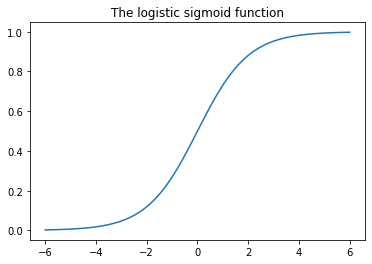

In [0]:
z = linspace(-6,6,100)
plot(z, 1/(1+exp(-z)))
title('The logistic sigmoid function')

## Logistic regression hypothesis

Our hypothesis space contains functions $h(x;\Theta) = \sigma(\Theta^Tx)$. Since for all $x$ we have that $h(x,\Theta)\in[0,1]$, we can treat the value $h(x,\Theta)$ as the conditional probability of the sample $x$ belonging to class 1:

$$
p(y=1|x;\Theta) = h(x,\Theta) = \sigma(\Theta^Tx) = \frac{1}{1+e^{-\Theta^Tx}}
$$

## Logistic regression loss function

We will again use the maximum likelihood principle. Please observe that:

$$
\begin{align}
p(y=y^{(i)}|x^{(i)};\Theta) &= \cases{p(y=1|x;\Theta) &if $y^{(i)}=1$ \\ 1-p(y=1|x;\Theta) &if $y^{(i)}=0$} \\
&= p(y=1|x;\Theta)^{y^{(i)}}(1-p(y=1|x;\Theta))^{(1-y^{(i)})} \\
&= \sigma(\Theta^Tx)^{y^{(i)}}(1-\sigma(\Theta^Tx))^{(1-y^{(i)})}
\end{align}
$$

Therefore the negative log likelihood ($nll$) is:
$$
\begin{split}
nll(\Theta) &= -\sum_{i=1}^{N} y^{(i)} \log \sigma(\Theta^Tx) + (1-y^{(i)})\log(1-\sigma(\Theta^Tx)) = \\
&= -\sum_{i=1}^{N}y^{(i)}\log p(y=1|x^{(i)}; \Theta) + (1-y^{(i)})\log  p(y=0|x^{(i)}; \Theta)
\end{split}
$$

This loss function is often referred to as the *cross-entropy* loss.

## Logistic regression training

To fit the logistic regression model we will again need to compute the gradient of the loss function. We will do it in steps. First please observe how simple is the gradient of the logistic sigmoid function:

$$ \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1-\sigma(z))$$

Now let $z^{(i)} = \Theta^Tx^{(i)}$. First lets compute the gradient of the loss on a single sample $nll^{(i)}$:

$$
\frac{\partial nll^{(i)}(\Theta)}{\partial \Theta} = \frac{\partial nll^{(i)}}{\partial z^{(i)}}\frac{\partial z^{(i)}}{\partial\Theta}
$$

The derivative of the first term on the right hand turns out to be very simple:

$$
\begin{align}
\frac{\partial nll^{(i)}}{\partial z^{(i)}} &= \frac{\partial -\left(y^{(i)} \log \sigma(z^{(i)}) + (1-y^{(i)})\log(1-\sigma(z^{(i)}))\right)}{\partial z^{(i)}} \\
&= -y^{(i)}\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{\sigma(z^{(i)})} + 
(1-y^{(i)})\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{1-\sigma(z^{(i)})} \\
&= -y^{(i)}(1-\sigma(z^{(i)})) + (1-y^{(i)})\sigma(z^{(i)})\\
&=\sigma(z^{(i)})-y^{(i)}
\end{align}
$$

The second term $\frac{\partial z^{(i)}}{\partial\Theta}$ is also easy:

$$
\frac{\partial z^{(i)}}{\partial\Theta} = \frac{\partial \Theta^Tx^{(i)}}{\partial\Theta} = x^{(i)}
$$

Taken together the loss derivative is:

$$
\frac{\partial nll(\Theta)}{\partial \Theta} = \sum_{i=1}^{N}\frac{\partial nll^{(i)}}{\partial z^{(i)}} = \sum_{i=1}^{N}\left(\sigma(z^{(i)})-y^{(i)}\right)x^{(i)}
$$

The expression can be further simplified by using the data matrix $X$ (whose $i$-th column is the $i$-th sample), the target matrix $Y$, letting $Z=\Theta^T X$, and assuming that the function $\sigma()$ is applied separately to all elements of its input.

$$
\frac{\partial nll(\Theta)}{\partial \Theta} = X\left(\sigma(Z)-Y\right)^T
$$

Unfortunately, the gradient of the loss is no longer linear with $\Theta$. No closed-form solution exists. Therefore we will search for the minimum of the loss function by taking small steps along the gradient of the loss. We will call this the **gradient descent**.

## The Gradient Descent algorithm

The algorithm is very simple:

* $\Theta \gets $ a sane initial value
* `While` not bored:
    * 
$\Theta \gets \Theta - \alpha \frac{\partial L(\Theta)}{\partial\Theta}$

We make many $\alpha$-long steps along the gradient, hoping to reach the optimum. 

In [0]:
# Note - we divide the height by 100.
# Otherwise the simple GD algorithm will have trouble converging.
X = np.vstack((np.ones_like(data.height), data.height/100.)).astype(float)
print('X has shape', X.shape)

Y = np.asarray(data.sex=='M')[None,:]
print('Y has shape', Y.shape)

X has shape (2, 200)
Y has shape (1, 200)


In [0]:
#note: the step-size needs to be tuned!
ThetaOpt, history = logreg(X, Y, alpha=1e-0, stop_tolerance=1e-8, max_steps=100000)
print(len(history))
print(ThetaOpt)

56407
[-63.1462792   36.77890007]


In [0]:
fig = plt.figure()
ax = plt.axes(xlim=(1.40,2.05), ylim=(-0.2, 1.2))
ax.scatter(X[1,:], Y[0,:], c=Y[0,:], cmap='spring')

xx = np.vstack((np.ones((100,)), np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)))
num_frames=100
line, = ax.plot([],[])

xlabel('height [m]')
ylabel('sex 1-Man, 0-Woman')
grid(True)
plt.close()


def init():
    line.set_data([], [])
    return line,

def animate(i):
    epoch = int(1.0*len(history)/num_frames*i)
    Theta = history[epoch]
    ax.set_title('Epoch %d, Theta: %s' % (epoch, Theta,))
    yy = 1.0/(1.0 + np.exp(-Theta.T.dot(xx)))
    line.set_data(xx[1,:], yy)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=30, blit=True)
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

## Softmax regression - dealing with multiple classes

When we have $k$ classes we need a model that can predict the probability distribution over all classes. An easy solution is to assume that our model has $k$ outputs, each in the range $[0,1]$ and summing to $1$.

Typically, we will learn a set of parameters for each class. Therefore, $\Theta$ will be a matrix of size $n \times k$ where $n$ is the number of data features (including the bias terms), and $k$ is the number of classes. Therefore $z = \Theta^T x$ will be a vector of $k$ per-class scores. We will normalize them using the SoftMax function:

$$
\text{SoftMax}(z)_j = \frac{e^{z_j}}{\sum_k e^{z_k}}
$$

The model learns the function

$$
h(x, \Theta) = \text{SoftMax}(\Theta^Tx).
$$

The SoftMax regression loss is the $k$-class cross-entropy:

$$
J(\Theta) = -\sum_{i=1}^N\sum_k[y^{(i)}=k]\log \left(h(x^{(i)}, \Theta)_k\right)
$$

where $[y^{(i)}=k]$ is an indicator function which tajes value 1 if $y^{(i)}=k$ and 0 otherwise.

### Examples of softmax regression

We can look at the results of softmax regression by picturing the parameters learned for each class.

We will use two datasets containing images - MNIST and CIFAR10. They both contain samples belonging to 10 classes. Therefore for each dataset we will find a set of parameters for each of the 10 classes. Then we will display the parameters as images. We can think about them as prototype vectors sensitive to elements of a given class.

In [0]:
with np.load('mnist.npz') as data:
    mnist_train_data = data[
        'train_data'].astype(np.float32).reshape(-1, 28*28).T / 255.0
    mnist_train_labels = data['train_labels']
    mnist_test_data = data[
        'test_data'].astype(np.float32).reshape(-1, 28*28).T / 255.0
    mnist_test_labels = data['test_labels']

In [0]:
# note: we want to keep the number of iterations low, afterwards we may 
# start to overfit. This will firther explained in later lectures.
ThetaMnist = softmax_regression(
    mnist_train_data, mnist_train_labels, 10, maxiter=25)

In [0]:
predicted_train_labels = ThetaMnist.T.dot(mnist_train_data).argmax(0)
print ("Train error rate: %f" % ((predicted_train_labels != mnist_train_labels).mean(), ))

predicted_test_labels = ThetaMnist.T.dot(mnist_test_data).argmax(0)
print ("Test error rate: %f" % ((predicted_test_labels != mnist_test_labels).mean(), ))

Train error rate: 0.084367
Test error rate: 0.082900


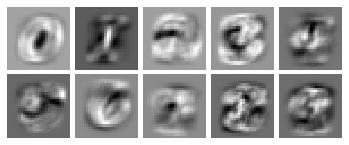

In [0]:
plot_mat(ThetaMnist[:,:].reshape(28,28,1,-1).transpose(3,2,0,1), cmap='gray')

In [0]:
with np.load('cifar.npz') as data:
    cifar_train_data = data[
        'train_data'].astype(np.float32).reshape(-1, 32*32*3).T / 255.0
    cifar_train_labels = data['train_labels']
    cifar_test_data = data[
        'test_data'].astype(np.float32).reshape(-1, 32*32*3).T / 255.0
    cifar_test_labels = data['test_labels']

In [0]:
# note: we want to keep the number of iterations low, afterwards we may 
# start to overfit. This will befurther explained in later lectures
ThetaCifar = softmax_regression(
    cifar_train_data, cifar_train_labels, 10, maxiter=50)

In [0]:
predicted_train_labels = ThetaCifar.T.dot(cifar_train_data).argmax(0)
print ("Train error rate: %f" % ((predicted_train_labels != cifar_train_labels).mean(), ))

predicted_test_labels = ThetaCifar.T.dot(cifar_test_data).argmax(0)
print ("Test error rate: %f" % ((predicted_test_labels != cifar_test_labels).mean(), ))

Train error rate: 0.598300
Test error rate: 0.607700


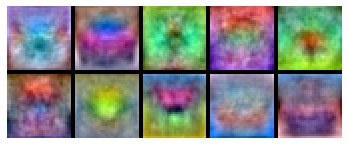

In [0]:
# We skip the first row of parameters because they represent the 
# constant term. The remaming ones are rehsaped as RGB images
#
# The 10 classes are:
# ------------------------------------------------
# | airplane | automobile | bird  | cat  | deer  |
# |----------|------------|-------|------|-------|
# |   dog    |     frog   | horse | ship | truck |
# ------------------------------------------------
#
# Again, the learned parameters ressebmle the average image in each class.
#
plot_mat(ThetaCifar[:,:].reshape(32,32,3,-1).transpose(3,2,0,1))

# Relationship between Logistic Regression loss and AdaBoost loss

Both AdaBoost and Logistic regression compute a score $h(x)$:
- In AdaBoost $h(x) = \sum_j \alpha_j h_j(x)$, where $h_j$ is the $j-$th weak classifier and $\alpha_j$ are weights.
- In Loistic Regression $h(x) = \Theta^T x$ with $\Theta$ a parameter vector.

Moreover, both methods have the same decision rule $y=1$ if and only if $h(x) \geq 0$.

Similarly, both are trained to minimize a loss function:
- AdaBosst minimizes $$
\begin{cases}
e^{-h(x)}&\text{ if }y=1 \\
e^{h(x)}&\text{ if }y\neq 1
 \end{cases}
 =e^{-yh(x)}
 $$ when $y\in{-1, 1}$
- Logistic Regrassion minimizes 
$$
\begin{split}
nll &= \begin{cases}
-\log p(y=1|x)&\text{ if }y=1 \\
-\log(1 - p(y=1|x))&\text{ if }y\neq 1
\end{cases} \\
 &= -y \log p(y=1|x) - (1-y)\log(1 - p(y=1|x)) \\
 &= -y \log \sigma(h(x)) - (1-y)\log(1 - \sigma(h(x)))
\end{split}
$$ when $y\in{0,1}$.

To get a better insight into the relationship between the two functions we will find an alternative formulation for the Logistic Regression Loss.
$$
\begin{split}
nll &= \begin{cases}
-\log p(y=1|x)&\text{ if }y=1 \\
-\log(1 - p(y=1|x))&\text{ if }y\neq 1
\end{cases} \\
&= \begin{cases}
-\log \frac{1}{1+e^{-h(x)}} &\text{ if }y=1 \\
-\log \frac{1}{1+e^{h(x)}} &\text{ if }y\neq 1
\end{cases} \\
&= \log(1+e^{-y h(x)})
\end{split}
$$ when $y\in{-1, 1}$.

Thus, we can alternatively view the logistic regression loss as $\log(1+e^{-y h(x)})$.

Below we plot 3 loss functions for the case when $y=1$:
- the 0-1 loss $\text{sign}(h(x)) = 1$,
- the exponential loss from AdaBoost $e^{-yh(x)}$,
- the cross-entropy from Logistic Regression $\log(1+e^{-yh(x)})$

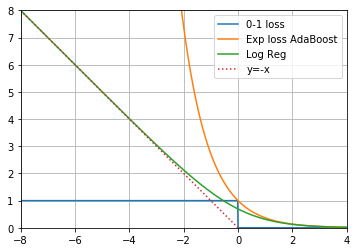

In [0]:
#@title Loss Comparison
h = np.linspace(-8, 4, 1000)
plt.plot(h, h<0, label='0-1 loss')
plt.plot(h, np.exp(-h), label='Exp loss AdaBoost')
plt.plot(h, np.log(1 + np.exp(-h)), label='Log Reg')
plt.plot([h[0], 0], [-h[0], 0], ':', label='y=-x')
plt.axis('square')
plt.ylim(0, -h[0])
plt.xlim(h[0], h[-1])
plt.grid(True)
plt.legend()

As we can see, both exponential loss, and the logistic loss (after scaling) can be seen as upper bounds on the 0-1 loss:
- they both tend to zero if the model is confidently correct,
- they both grow to infinity if the model is confidently incorrect.

However, the logistic regression loss grows linearly with the magnitude of the error, and the Adaboost's loss grows exponentially fast. This has a practical implication: a model trained with the AdaBoost's loss will make more to avoid training misclassifications, which can make the model more prone to outliers.

In fact, the [LogitBooost algorithm](https://projecteuclid.org/download/pdf_1/euclid.aos/1016218223) was designed to merge the logistic regression loss with boosting!

# Further reading
1. Andrew Ng "CS229 Lecture notes", http://cs229.stanford.edu/notes/cs229-notes1.pdf
2. Leon Bottou "Stochastic Gradient Descent Tricks", http://leon.bottou.org/papers/bottou-tricks-2012